<a href="https://www.kaggle.com/code/michaelmortenson/help-first-time-pca-here?scriptVersionId=102210804" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Tabular Playground Series - July 2022

By Michael Mortenson

The dataset for this challenge is simulated manufacturing control data. The goal is to use unsupervised (clustering) to identify different control states. We are not told the number of control states, the units, time dependencies, or any other information about the data.

## Domain Insights

Manufacturing products requires raw materials to be processed through a series of steps (and often many machines). Each step will not be perfectly exact, so the engineering design will have tolerances for the manufacture of each piece of a product. The job of manufacturing control to ensure that production stays efficient by detecting problems as machine pieces begin to wear, devices lose their calibration, or other problems arise.

Since we are not told what each column in the data represents, we will need to analyze to decide how we should treat it. 

In [1]:
# Useful Packages
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Read in data
X = pd.read_csv('/kaggle/input/tabular-playground-series-jul-2022/data.csv')

## General Visualization

Let's take a look at the general spread of the data in each column of our dataset.

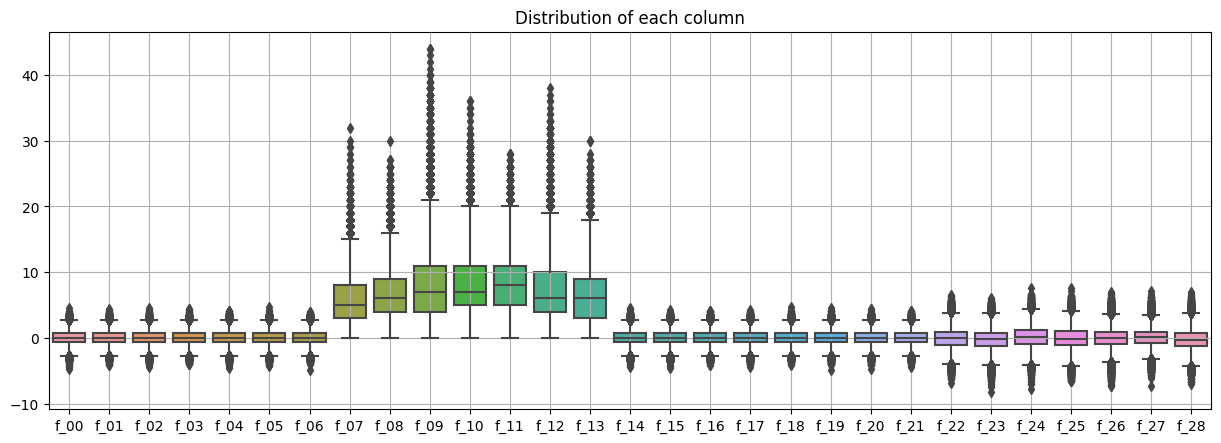

In [3]:
X1 = X.drop(columns='id')
plt.figure(dpi=100, figsize=(15, 5))
sns.boxplot(data=X1)
plt.grid(True)
plt.title("Distribution of each column")
plt.show()

I visually see that there are 4 main groupings here:
* 00-06, float data, normally distributed. Probably dimension tolerance data.
* 07-14. integer data, categorical counts, skewed (Poisson?). Probably counting some kind of feature.
* 15-21, float data, normally distributed. Probably more dimension tolerance data. Very similar to 00-06.
* 22-28, float data, normally distributed. Mean drifts and spread is wider than the other float data categories.

### PCA - Principle Component Analysis

From what I can tell, PCA requires that you center your data and normalize it so that the variance is consistent across features. The Yeo-Johnson tranformation (default for sklearn's PowerTransformer) improves the normality of data, so I will go with that, but I am open to other ideas.

In [4]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
X_tran = pt.fit_transform(X1)

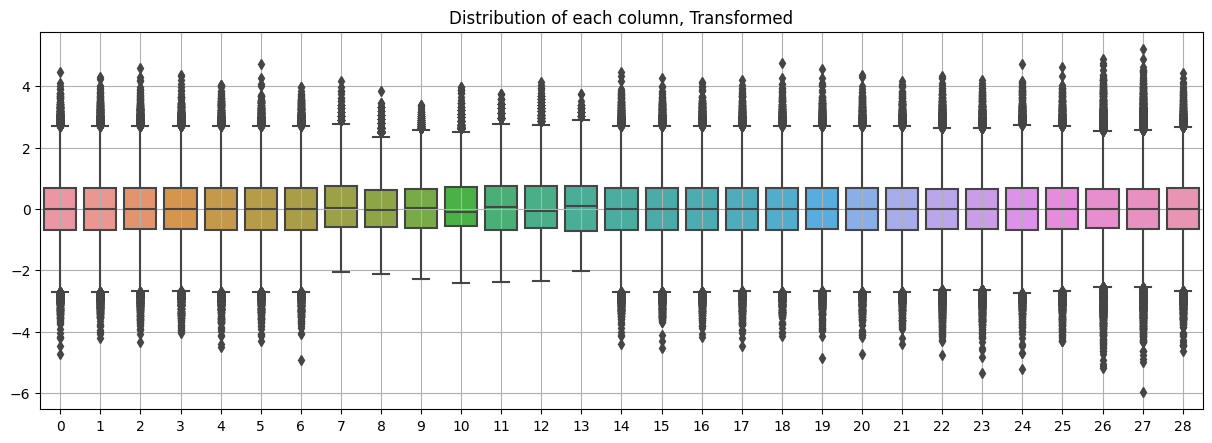

In [5]:
# Visualize the tranformed data
plt.figure(dpi=100, figsize=(15, 5))
sns.boxplot(data=X_tran)
plt.grid(True)
plt.title("Distribution of each column, Transformed")
plt.show()

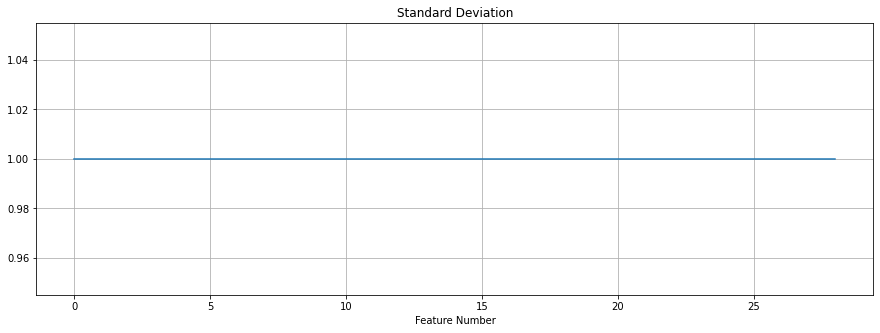

In [6]:
# Verify that the standard deviation of the tranformed data is consistent.
std = np.std(X_tran, axis=0)
fig, ax = plt.subplots(figsize=[15,5])
ax.plot(std)
ax.set_title("Standard Deviation")
ax.set_xlabel("Feature Number")
ax.grid(True)

In [7]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_tran)
var_ratio = pca.explained_variance_ratio_
exp_var = pca.explained_variance_
sing_vals = pca.singular_values_
components = pca.components_

The singular values show the relative 'strength' of each component (see info on how the singular value decomposition relates to PCA).

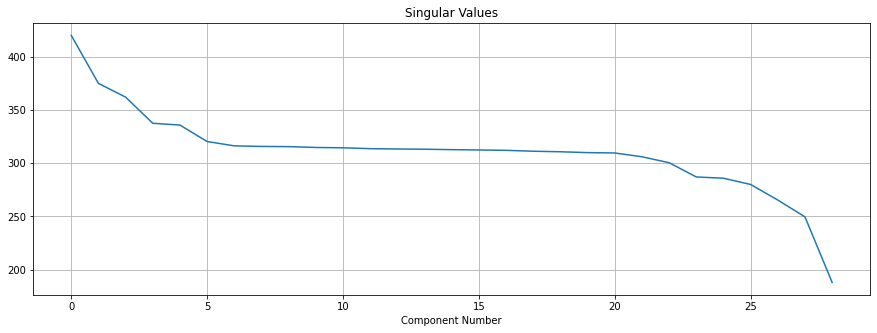

In [8]:
fig, ax = plt.subplots(figsize=[15,5])
ax.plot(sing_vals)
ax.set_title("Singular Values")
ax.set_xlabel("Component Number")
ax.grid(True)

The main "elbow" occurs from 5 or 6 on, which would indicate the first 6 or 7 components are the most informative.

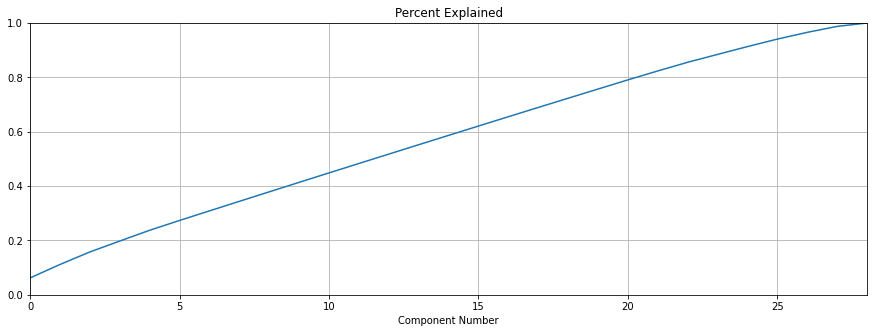

In [9]:
# Cumulative proportion of variance (from PC1 to PC6)   
percent_explained = np.cumsum(var_ratio)

fig, ax = plt.subplots(figsize=[15,5])
ax.plot(percent_explained)
ax.set_title("Percent Explained")
ax.set_xlabel("Component Number")
ax.set_xlim([0,28])
ax.set_ylim([0,1])
ax.grid(True)
plt.show()

I find it a bit odd that the components look to be accounting for about equal variance in the data. Would this suggest they are all important, or did I mess up in the computation?

* Kaggle hero suggested that the equal variance may be due to the Yeo-Johnson transformation (which makes features have similar variance).

What would you suggest for how to move forward? Are there other visualizations or analyses I could do? Is PCA good enough, or is there another (nonlinear?) transformation that would be better?

* One Kaggle hero suggested that I try PCA on each other "groups" without any preprocessing, since they seem to have similar behaviors within each group. I will try this next.

## PCA on each group

In [10]:
# The group labels
g1 = [f"f_{x:02d}" for x in range(7)]
g2 = [f"f_{x:02d}" for x in range(7, 14)]
g3 = [f"f_{x:02d}" for x in range(14, 22)]
g4 = [f"f_{x:02d}" for x in range(22, 29)]
g_label_list = [g1, g2, g3, g4]

# The group data
X_g1 = X1[g1].copy()
X_g2 = X1[g2].copy()
X_g3 = X[g3].copy()
X_g4 = X1[g4].copy()
g_data = [X_g1, X_g2, X_g3, X_g4]

In [11]:
# Initialize Storage
var_ratios = []
exp_vars = []
sing_val_list = []
comp_list = []
projections = []

# Loop through groups
for data in g_data:
    pca = PCA()
    projection = pca.fit_transform(data)
    projections.append(projection)
    var_ratios.append(pca.explained_variance_ratio_)
    exp_vars.append(pca.explained_variance_)
    sing_val_list.append(pca.singular_values_)
    comp_list.append(pca.components_)

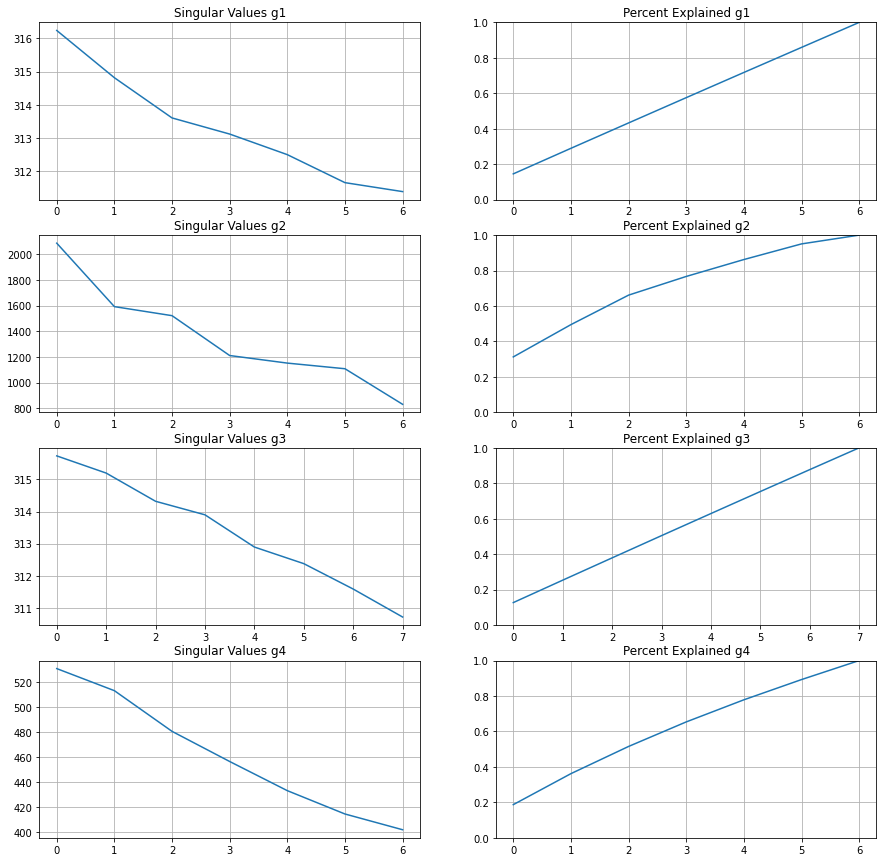

In [12]:
# Singular Value Plots
fig, ax = plt.subplots(nrows=len(g_label_list), ncols=2, figsize=[15,15])
group_names = ['g1', 'g2', 'g3', 'g4']

for idx, label in enumerate(group_names):
    ax[idx,0].plot(sing_val_list[idx])
    ax[idx,0].set_title(f"Singular Values {label}")
    ax[idx,0].grid(True)
    
    percent_explained = np.cumsum(var_ratios[idx])
    ax[idx,1].plot(percent_explained)
    ax[idx,1].set_title(f"Percent Explained {label}")
    ax[idx,1].set_ylim([0,1])
    ax[idx,1].grid(True)

plt.show()

The Gaussian distributed groups all have similar looking plots to the total PCA plots, but the skewed, integer count group seems to have some variation. 

I wonder what would happen if I did t-SNE or UMAP (see below) on the new PCA stuff.

### t-SNE : t-Distributed Stochastic Neighbor Embedding

One method for visualizing the data that was recommened to me following my original posting was t-SNE. 

In doing some basic googling, it uses the KL-divergence to create a low-dim embedding of  high-dimensional data.

Things to remember:
* t-SNE is not convex (intialization-dependent results)
* perplexity needs to be less than the number of points (easy here)
* Cluster sizes in a t-SNE plot mean nothing
* Distances btween clusters is also not informative
* Lower perplexity captures the local structures better and higher perplexity captures the global structures better.


In [13]:
from sklearn.manifold import TSNE
X2 = X1.sample(frac=.10, random_state=0)

In [14]:
perplexities = [5.0, 10.0, 20.0, 30.0, 40.0, 50.0]
embeddings = []
for perplexity in perplexities:
    tsne = TSNE(n_components=2, learning_rate='auto', perplexity=perplexity, verbose=1)
    X_embedded = tsne.fit_transform(X2)
    embeddings.append(X_embedded)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.000s...
[t-SNE] Computed neighbors for 9800 samples in 2.249s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 1.983952
[t-SNE] KL divergence after 250 iterations with early exaggeration: 108.270378
[t-SNE] KL divergence after 1000 iterations: 2.666757
[t-SNE] Computing 31 nearest neighbor

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 2.204s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 2.381000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 103.149796
[t-SNE] KL divergence after 1000 iterations: 2.800069
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.000s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 2.240s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 2.722398
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.001968
[t-SNE] KL divergence after 1000 iterations: 2.780908
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.000s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 2.281s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 2.911853
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.089935
[t-SNE] KL divergence after 1000 iterations: 2.727319
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.000s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 2.357s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 3.045577
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.256927
[t-SNE] KL divergence after 1000 iterations: 2.639231
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.000s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 2.386s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 3.150233
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.082489
[t-SNE] KL divergence after 1000 iterations: 2.588454


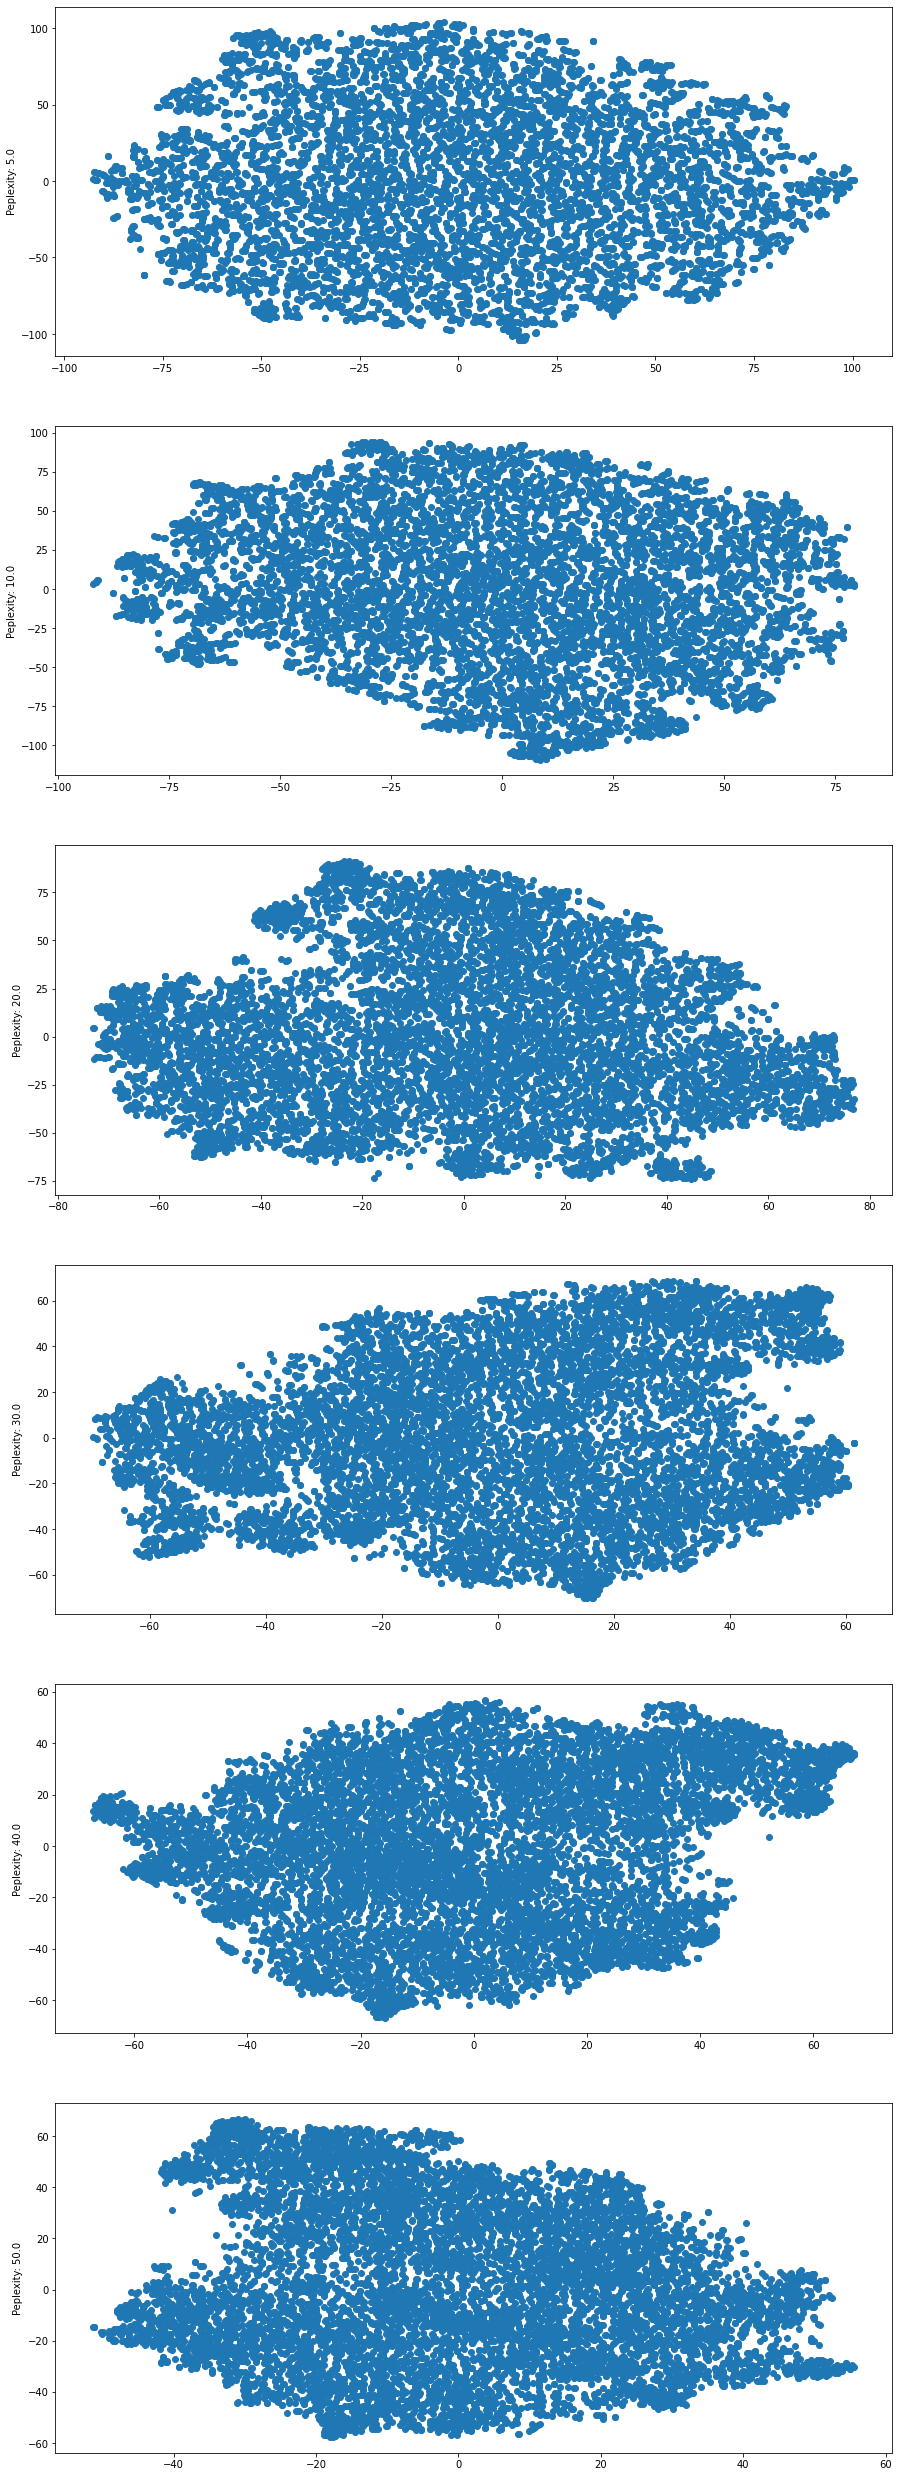

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=len(perplexities), figsize=[15,45])

for idx, perplexity in enumerate(perplexities):
    x = embeddings[idx][:,0]
    y = embeddings[idx][:,1]
    ax[idx].scatter(x,y)
    ax[idx].set_ylabel(f"Peplexity: {perplexity}")

plt.show()

So, t-sne doesn't look like it's giving great results. Even varying perplexity, the data is not really splitting into different clusters.

# t-SNE on each PCA group

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.009s...
[t-SNE] Computed neighbors for 9800 samples in 0.616s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.392959
[t-SNE] KL divergence after 250 iterations with early exaggeration: 113.414108
[t-SNE] KL divergence after 1000 iterations: 2.549799
[t-SNE] Computing 16 nearest neighbor

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 0.427s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 1.474413
[t-SNE] KL divergence after 250 iterations with early exaggeration: 105.019043
[t-SNE] KL divergence after 1000 iterations: 2.171511
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.010s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 0.895s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.454367
[t-SNE] KL divergence after 250 iterations with early exaggeration: 114.963715
[t-SNE] KL divergence after 1000 iterations: 2.699567
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.010s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 0.558s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.551324
[t-SNE] KL divergence after 250 iterations with early exaggeration: 109.614304
[t-SNE] KL divergence after 1000 iterations: 2.284020
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.010s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 0.785s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.480837
[t-SNE] KL divergence after 250 iterations with early exaggeration: 108.258774
[t-SNE] KL divergence after 1000 iterations: 2.807823
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.010s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 0.593s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 1.842863
[t-SNE] KL divergence after 250 iterations with early exaggeration: 101.224792
[t-SNE] KL divergence after 1000 iterations: 2.300412
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.010s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 1.116s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.552156
[t-SNE] KL divergence after 50 iterations with early exaggeration: 110.090096
[t-SNE] KL divergence after 1000 iterations: 2.970118
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.010s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 0.743s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.677891
[t-SNE] KL divergence after 250 iterations with early exaggeration: 105.263115
[t-SNE] KL divergence after 1000 iterations: 2.457595
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.010s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 1.040s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.560275
[t-SNE] KL divergence after 50 iterations with early exaggeration: 102.157913
[t-SNE] KL divergence after 1000 iterations: 2.956620
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.010s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 0.750s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 2.164211
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.633728
[t-SNE] KL divergence after 1000 iterations: 2.339453
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.010s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 1.442s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.638690
[t-SNE] KL divergence after 50 iterations with early exaggeration: 101.908577
[t-SNE] KL divergence after 1000 iterations: 3.138515
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.010s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 0.979s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.793549
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.392784
[t-SNE] KL divergence after 1000 iterations: 2.557207
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.013s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 1.253s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.605934
[t-SNE] KL divergence after 50 iterations with early exaggeration: 97.320381
[t-SNE] KL divergence after 1000 iterations: 2.978250
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.010s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 0.916s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 2.353980
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.031174
[t-SNE] KL divergence after 1000 iterations: 2.313216
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.011s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 1.629s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.687577
[t-SNE] KL divergence after 50 iterations with early exaggeration: 97.081787
[t-SNE] KL divergence after 1000 iterations: 3.162438
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.010s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 1.181s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.860447
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.622108
[t-SNE] KL divergence after 1000 iterations: 2.561439
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.009s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 1.434s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.638763
[t-SNE] KL divergence after 50 iterations with early exaggeration: 93.880707
[t-SNE] KL divergence after 1000 iterations: 2.971934
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.009s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 1.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 2.492603
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.351730
[t-SNE] KL divergence after 1000 iterations: 2.265686
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.010s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 1.812s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.722350
[t-SNE] KL divergence after 50 iterations with early exaggeration: 93.650101
[t-SNE] KL divergence after 1000 iterations: 3.176492
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.009s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 1.345s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.908617
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.856308
[t-SNE] KL divergence after 1000 iterations: 2.544739
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.009s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 1.627s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.664735
[t-SNE] KL divergence after 50 iterations with early exaggeration: 91.211411
[t-SNE] KL divergence after 1000 iterations: 2.933794
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.009s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 1.220s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 2.603534
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.255562
[t-SNE] KL divergence after 1000 iterations: 2.235510
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.010s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 2.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.749642
[t-SNE] KL divergence after 50 iterations with early exaggeration: 90.990448
[t-SNE] KL divergence after 1000 iterations: 3.151087
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 9800 samples in 0.009s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9800 samples in 1.517s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9800
[t-SNE] Computed conditional probabilities for sample 2000 / 9800
[t-SNE] Computed conditional probabilities for sample 3000 / 9800
[t-SNE] Computed conditional probabilities for sample 4000 / 9800
[t-SNE] Computed conditional probabilities for sample 5000 / 9800
[t-SNE] Computed conditional probabilities for sample 6000 / 9800
[t-SNE] Computed conditional probabilities for sample 7000 / 9800
[t-SNE] Computed conditional probabilities for sample 8000 / 9800
[t-SNE] Computed conditional probabilities for sample 9000 / 9800
[t-SNE] Computed conditional probabilities for sample 9800 / 9800
[t-SNE] Mean sigma: 0.946745
[t-SNE] KL divergence after 50 iterations with early exaggeration: 91.232376
[t-SNE] KL divergence after 1000 iterations: 2.527892


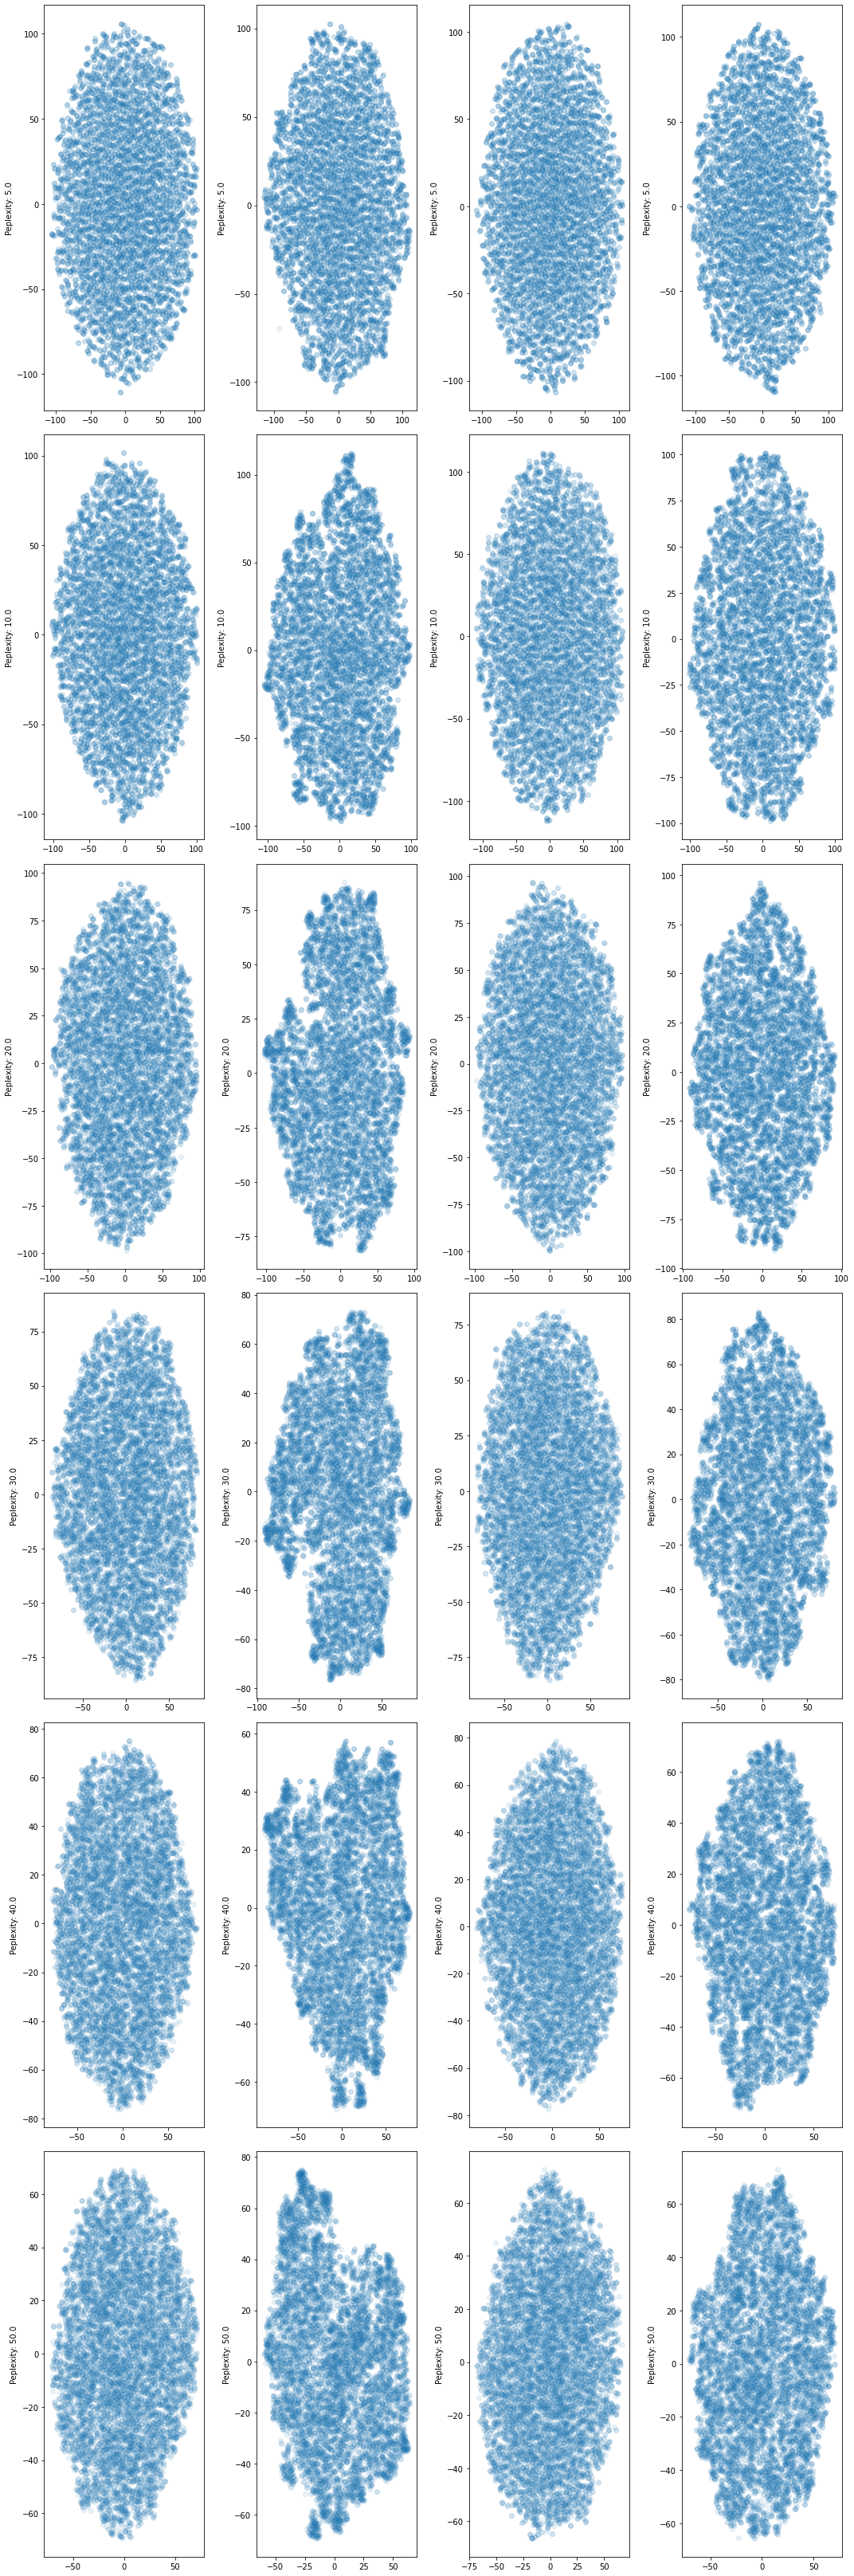

In [16]:
perplexities = [5.0, 10.0, 20.0, 30.0, 40.0, 50.0]

fig, ax = plt.subplots(ncols=len(projections), nrows=len(perplexities), figsize=[15,45])

for ridx, perplexity in enumerate(perplexities):
    for cidx, projection in enumerate(projections):
        
        tsne = TSNE(n_components=2, learning_rate='auto', perplexity=perplexity, verbose=1)
        projection_df = pd.DataFrame(projection)
        X_samp = projection_df.sample(frac=.10, random_state=0)
        X_embedded = tsne.fit_transform(X_samp)
        
        x = X_embedded[:,0]
        y = X_embedded[:,1]
        ax[ridx, cidx].scatter(x,y, alpha=0.1)
        ax[ridx, cidx].set_ylabel(f"Peplexity: {perplexity}")
        

plt.tight_layout()
plt.show()   

Running t-SNE on the PCA of each of the four groups doesn't give us much to go on either. Still blobs.

### UMAP

Some people have suggested using UMAP, so I will try it out and see how it goes.

In [17]:
import umap

In [18]:
neighbor_size = [5.0, 50.0, 100.0, 500.0]
umap_embeds = []
for n_neighbors in neighbor_size:
    reducer = umap.UMAP(random_state=0, n_neighbors=n_neighbors, n_components=2, verbose=True)
    
    # Fit the umap enbedding with the PowerTransformer normalized data
    X_embed = reducer.fit_transform(X_tran)
    umap_embeds.append(X_embed)

UMAP(n_neighbors=5.0, random_state=0, verbose=True)
Sun Jul 31 22:40:14 2022 Construct fuzzy simplicial set
Sun Jul 31 22:40:14 2022 Finding Nearest Neighbors
Sun Jul 31 22:40:14 2022 Building RP forest with 21 trees
Sun Jul 31 22:40:20 2022 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
	 8  /  17
	 9  /  17
	Stopping threshold met -- exiting after 9 iterations
Sun Jul 31 22:40:40 2022 Finished Nearest Neighbor Search
Sun Jul 31 22:40:44 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sun Jul 31 22:41:38 2022 Finished embedding
UMAP(n_neighbors=50.0, random_state=0, verbose=True)
Sun Jul 31 22:41:38 2022 Construct fuzzy simplicial set
Sun Jul 31 22:41:38 2022 Finding Nearest Neighbors
Sun Jul 31 22:41:38 2022 Building RP forest with 21 trees
Sun Jul 31 22:41:41 2022 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	Stopping threshold met -- exiting after 5 iterations
Sun Jul 31 22:42:09 2022 Finished Nearest Neighbor Search
Sun Jul 31 22:42:11 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sun Jul 31 22:44:50 2022 Finished embedding
UMAP(n_neighbors=100.0, random_state=0, verbose=True)
Sun Jul 31 22:44:50 2022 Construct fuzzy simplicial set
Sun Jul 31 22:44:50 2022 Finding Nearest Neighbors
Sun Jul 31 22:44:50 2022 Building RP forest with 21 trees
Sun Jul 31 22:44:51 2022 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	Stopping threshold met -- exiting after 5 iterations
Sun Jul 31 22:45:52 2022 Finished Nearest Neighbor Search
Sun Jul 31 22:45:57 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sun Jul 31 22:49:26 2022 Finished embedding
UMAP(n_neighbors=500.0, random_state=0, verbose=True)
Sun Jul 31 22:49:26 2022 Construct fuzzy simplicial set
Sun Jul 31 22:49:26 2022 Finding Nearest Neighbors
Sun Jul 31 22:49:26 2022 Building RP forest with 21 trees
Sun Jul 31 22:49:27 2022 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
	 8  /  17
	 9  /  17
	Stopping threshold met -- exiting after 9 iterations
Sun Jul 31 22:56:15 2022 Finished Nearest Neighbor Search
Sun Jul 31 22:56:41 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sun Jul 31 23:02:16 2022 Finished embedding


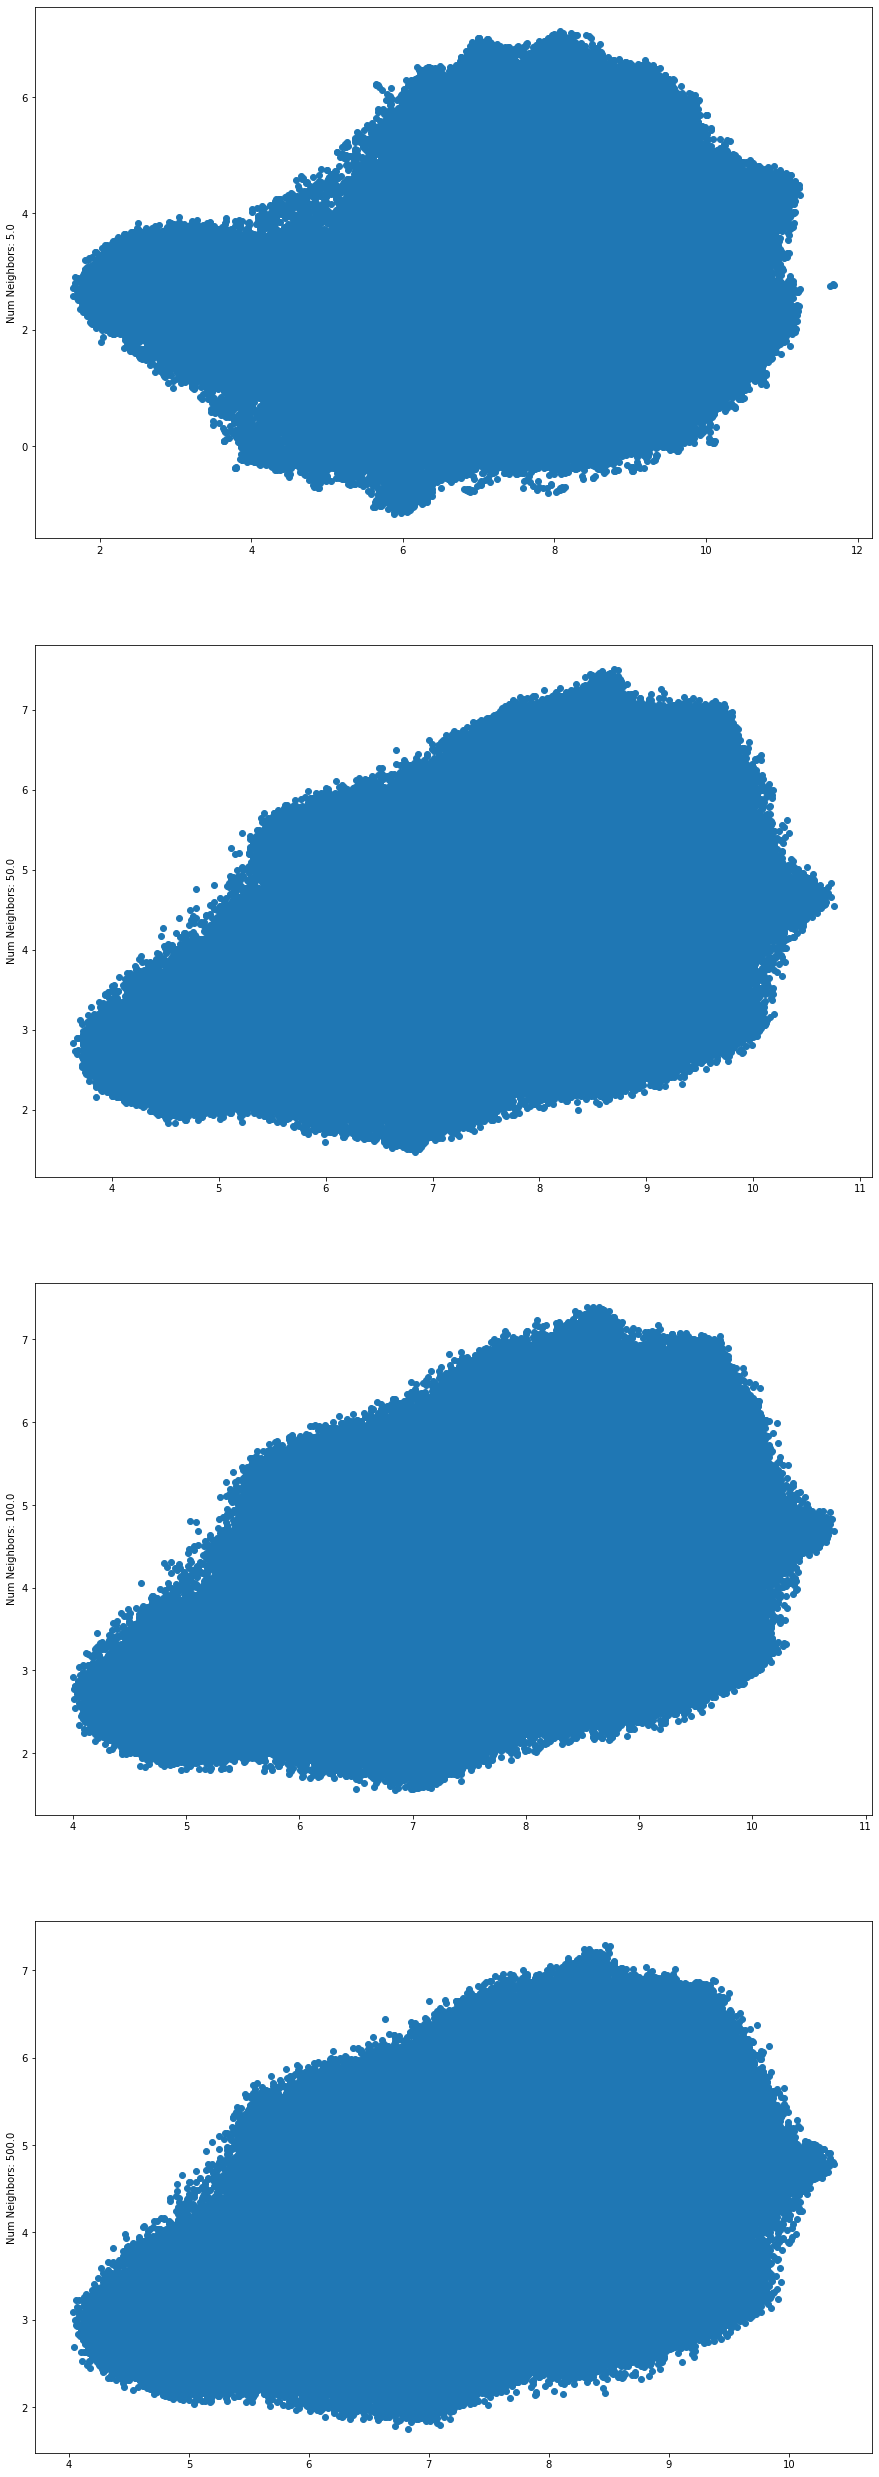

In [19]:
fig, ax = plt.subplots(ncols=1, nrows=len(neighbor_size), figsize=[15,45])

for idx, n_neighbors in enumerate(neighbor_size):
    x = umap_embeds[idx][:,0]
    y = umap_embeds[idx][:,1]
    ax[idx].scatter(x,y)
    ax[idx].set_ylabel(f"Num Neighbors: {n_neighbors}")

plt.show()

The UMAP is just as single-cluster-y as t-sne, so it looks like PCA gives us the most info (even though it's not much). 

If you have tips for how to improve the umap or t-SNE visualization, let me know. :)

### Clustering - Gaussian Mixture Model

nTry out clustering with the first 7 components of PCA. People have indicated that this is a good place to start, so let's start there. Also, I tried k-means and it wasn't great, so let's try the more flexible GMM.

In [20]:
# Set number of components
num_comps = 6

# Grab components from PCA
pca = PCA(n_components=num_comps)
pca_array = pca.fit_transform(X_tran)
pca_df = pd.DataFrame(pca_array)


In [21]:
from sklearn.mixture import GaussianMixture

# Intialize the GMM model
gmm = GaussianMixture(n_components = num_comps, random_state=0)

# Fit the GMM model for the dataset
gmm.fit(pca_df)

# Assign a label to each sample
labels = gmm.predict(pca_df)
pca_df['Clusters']= labels

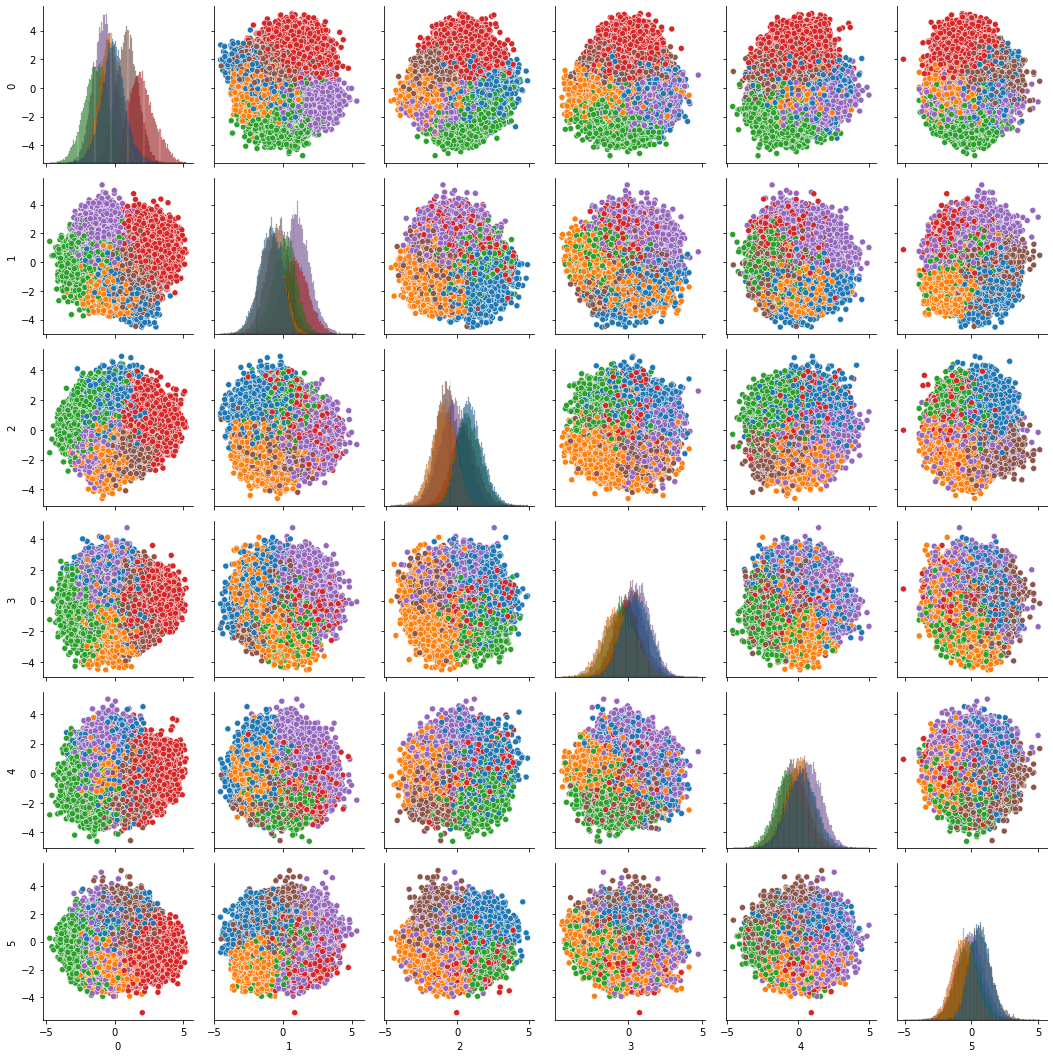

In [22]:
# Visualize the clusters and their distributions
g = sns.PairGrid(pca_df, vars=list(range(num_comps)), hue="Clusters", palette="tab10")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

Wow! Some of these clusters look very distinct, which is great. This is especially true of the first couple columns (which is consistent with the idea of principle components). Let's try submitting and see how it does. My previous best scroe was 0.24602.

### 4-part PCA Clustering

I want to try doing clustering using the top 3 components of each of the 4 subgroups' individual PCAs.

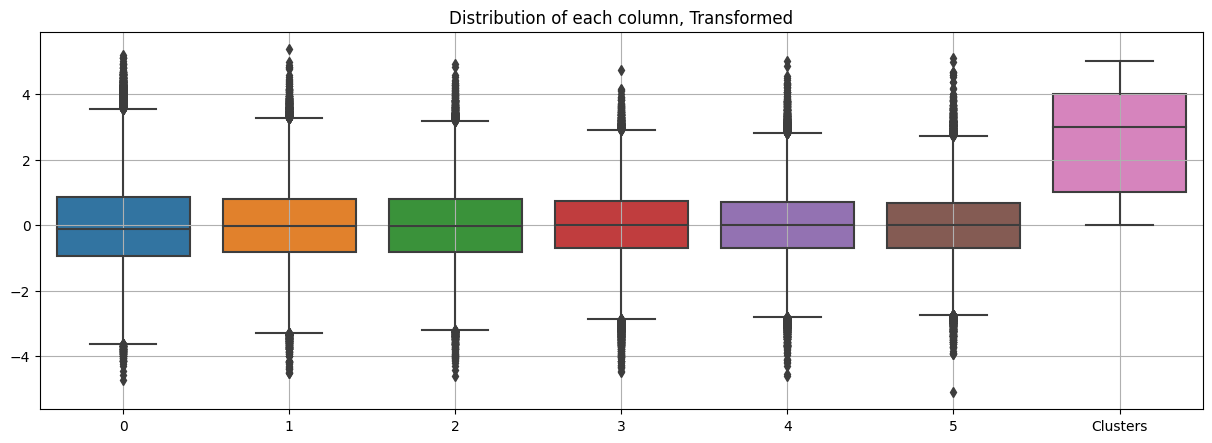

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [23]:
# Combine the top j components of each group into one
j = 3

top_g1 = projections[0][:,:j]
top_g2 = projections[1][:,:j]
top_g3 = projections[2][:,:j]
top_g4 = projections[3][:,:j]

new_data = np.concatenate((top_g1, top_g2, top_g3, top_g4), axis=1)
pca = PCA()
new_data = pca.fit_transform(new_data)

# pt = PowerTransformer(method='yeo-johnson')
# new_data = pt.fit_transform(new_data)
# pca_df = pd.DataFrame(new_data)

# Visualize the tranformed data
plt.figure(dpi=100, figsize=(15, 5))
sns.boxplot(data=pca_df)
plt.grid(True)
plt.title("Distribution of each column, Transformed")
plt.show()

# Intialize the GMM model
gmm = GaussianMixture(n_components = num_comps, random_state=0)

# Fit the GMM model for the dataset
gmm.fit(pca_df)

# Assign a label to each sample
labels = gmm.predict(pca_df)
pca_df['Clusters']= labels

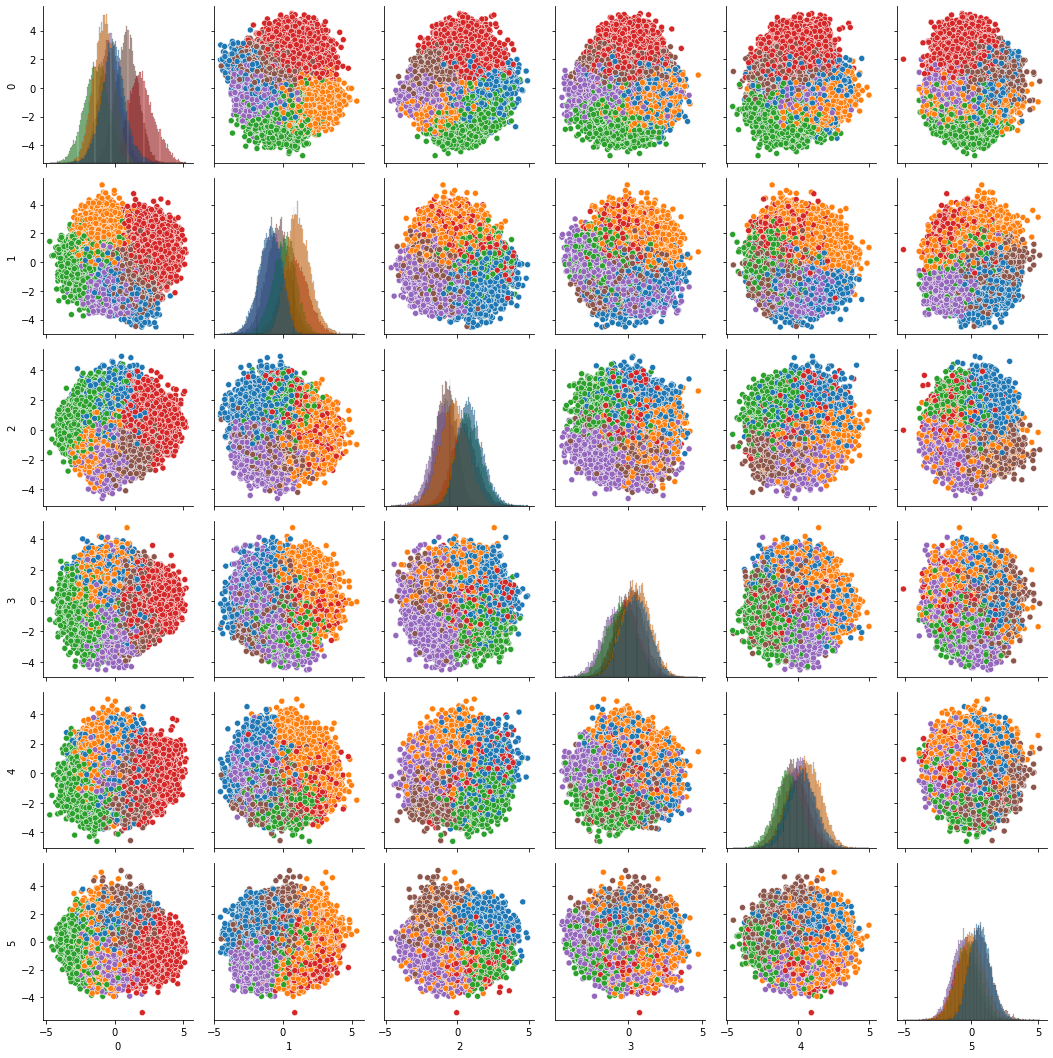

In [24]:
# Visualize the clusters and their distributions
g = sns.PairGrid(pca_df, vars=list(range(num_comps)), hue="Clusters", palette="tab10")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

In [25]:
# Prep for submission
submission = pd.DataFrame()
submission['id'] = pca_df.index
submission['Predicted'] = pca_df.loc[:,['Clusters']]
submission.shape

(98000, 2)

In [26]:
# Save for submitting
submission.to_csv('submission.csv',index=False)

Cool! With 7 GMM components, that gave me a score of 0.27272. An improvement of 0.03 over using my previous method (which was just straight k-means).

I wonder how I would do with different numbers of components?

* With 6 GMM components, I get a score of 0.28254, an improvment of another 0.1.
* With 5 GMM components, I get a score of 0.22158, a backslide in performance. 

Splitting the data into the 4 groups I observed visually, and doing PCA in each one, I thought it might be interesting to use the top couple components with the GMM model to try and cluster the data.
* For 5 GMM components with the top 3 of each group's PCA components I get a score of 0.25911
* For 6 GMM components with the top 2 of each group's PCA components I get a score of 0.17945 (Eek!)
* For 6 GMM components with the top 3 of each group's PCA components fed through a PCA, I get 0.27467 (Bettah!)
* For 6 GMM components with the top 3 of each group's PCA components fed through a PCA and PowerTransformer, I get 0.17736 (not better.)

Trying a slightly different tactic, I used the top 3 PCA components to create a dataset that I fed into PCA. I only trained the GMM on the top 3 overal components and got a score of 0.24391.
